<b> import statements

In [24]:
import sys

import numpy as np
import pandas as pd
import datetime
import time


import requests
import re
from bs4 import BeautifulSoup
from time import sleep
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style("whitegrid", {'axes.grid' : False})

In [25]:
from sklearn import cross_validation, datasets, linear_model, grid_search, metrics, ensemble, tree
from sklearn import pipeline, manifold, preprocessing, feature_selection, decomposition
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.learning_curve import learning_curve
from sklearn.cross_validation import cross_val_score

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [26]:
from pandas import Series, DataFrame, Panel
import scipy; 
import scipy.stats as stats; 
from scipy.stats import ttest_ind, ttest_ind_from_stats; from scipy.special import stdtr; 

<b> defining lobster

In [27]:
from pandas import DataFrame, read_csv, concat
from os import path
import numpy as np
from datetime import timedelta
from enum import Enum

class OrderEvent(Enum):
    SUBMISSION = 1
    CANCELLATION = 2
    DELETION = 3
    EXECUTION = 4
    HIDDEN_EXECUTION =5
    CROSS_TRADE = 6
    TRADING_HALT  = 7
    OTHER = 8

__EventMap = {}

for e in OrderEvent:
    __EventMap[e.value] = e

def get_orderEvent(eventid):
    return __EventMap[eventid]


class LobsterData:
    def __init__(self):
        self.order_books = None
        self.messages = DataFrame()
        self.level = 0

    def read_single_day_data(self, order_book_file, message_file, append=True, convert_time=False):
        file_name = path.basename(order_book_file)
        file_base = path.splitext(file_name)[0]
        mydate = np.datetime64('{0}T00:00-0000'.format(file_base.split('_')[1]))

        myorderbooks = read_csv(order_book_file, header=None)
        mymessages = read_csv(message_file, header=None)
        columns = []
        for iCol in range(int(len(myorderbooks.columns) / 4 + 0.5)):
            columns.append('Ask_Price_{0}'.format(iCol + 1))
            columns.append('Ask_Size_{0}'.format(iCol + 1))
            columns.append('Bid_Price_{0}'.format(iCol + 1))
            columns.append('Bid_Size_{0}'.format(iCol + 1))
        myorderbooks.columns = columns
        mymessages.columns = ['Time', 'Event', 'Order_ID', 'Size', 'Price', 'Direction']
        mymessages.Event = mymessages['Event'].map(get_orderEvent)
        mymessages['Date'] = mydate
        if convert_time:
            mymessages.Time = mymessages.Time.apply(lambda x: mydate + np.timedelta64(int(x * 1e9), 'ns'))

        mymessages.set_index(['Date', 'Time'], inplace=True)
        myorderbooks.index = mymessages.index

        if append:
            self.order_books = concat([self.order_books, myorderbooks], axis=0)
            self.messages = concat([self.messages, mymessages], axis=0)
        else:
            self.order_books = myorderbooks
            self.messages = mymessages
        self.level = int(self.order_books.shape[1] / 4 + 0.5)

    def read_period_data(self, ticker, level, start_date, end_date, data_path='./', **kwargs):
        my_date = start_date
        while my_date <= end_date:
            print('read {0}'.format(my_date.strftime('%Y-%m-%d')))
            order_book_file = "{0}/{1}_{2}_34200000_57600000_orderbook_{3}.csv".format(data_path, ticker,
                                                                                       my_date.strftime('%Y-%m-%d'),
                                                                                       level)

            message_file = "{0}/{1}_{2}_34200000_57600000_message_{3}.csv".format(data_path, ticker,
                                                                                       my_date.strftime('%Y-%m-%d'),
                                                                                       level)
            self.read_single_day_data(order_book_file, message_file, **kwargs)
            my_date += timedelta(1)

    def get_number_of_record(self):
        return self.order_books.shape[0]

    def get_number_of_level(self):
        return self.level

    def get_trades(self, combined=True, combination_interval=100):
        pass
    
    def exclude_trade_halt_data(self):
        halt_indicators = where(self.message.event == 7)
        
    def plot_orderbook(self):
        pass


Output Structure:
---------------

LOBSTER generates a 'message' and an 'orderbook' file for each active 
trading day of a selected ticker. The 'orderbook' file contains the 
evolution of the limit order book up to the requested number of levels. 
The 'message' file contains indicators for the type of event causing 
an update of the limit order book in the requested price range. All 
events are timestamped to seconds after midnight, with decimal 
precision of at least milliseconds and up to nanoseconds depending 
on the requested period. 


	Message File:		(Matrix of size: (Nx6))
	-------------	
			
	Name: 	TICKER_Year-Month-Day_StartTime_EndTime_message_LEVEL.csv 	
		
		StartTime and EndTime give the theoretical beginning 
		and end time of the output file in milliseconds after 		
		mid night. LEVEL refers to the number of levels of the 
		requested limit order book.


	Columns:
	
	    1.) Time: 		
				Seconds after midnight with decimal 
				precision of at least milliseconds 
				and up to nanoseconds depending on 
				the requested period
	    2.) Type:
				1: Submission of a new limit order
				2: Cancellation (Partial deletion 
				   of a limit order)
				3: Deletion (Total deletion of a limit order)
				4: Execution of a visible limit order			   	 
				5: Execution of a hidden limit order
				7: Trading halt indicator 				   
				   (Detailed information below)
	    3.) Order ID: 	
				Unique order reference number 
				(Assigned in order flow)
	    4.) Size: 		
				Number of shares
	    5.) Price: 		
				Dollar price times 10000 
				(i.e., A stock price of $91.14 is given 
				by 911400)
	    6.) Direction:
				-1: Sell limit order
				1: Buy limit order
				
				Note: 
				Execution of a sell (buy) limit
				order corresponds to a buyer (seller) 
				initiated trade, i.e. Buy (Sell) trade.
										
						
	Orderbook File:		(Matrix of size: (Nx(4xNumberOfLevels)))
	---------------
	
	Name: 	TICKER_Year-Month-Day_StartTime_EndTime_orderbook_LEVEL.csv
	
	Columns:
	
 	    1.) Ask Price 1: 	Level 1 Ask Price 	(Best Ask)
	    2.) Ask Size 1: 	Level 1 Ask Volume 	(Best Ask Volume)
	    3.) Bid Price 1: 	Level 1 Bid Price 	(Best Bid)
	    4.) Bid Size 1: 	Level 1 Bid Volume 	(Best Bid Volume)
	    5.) Ask Price 2: 	Level 2 Ask Price 	(2nd Best Ask)
	    ...
	
	Notes: 	 
	------
	
		- Levels:
		
		The term level refers to occupied price levels. This implies 
		that the difference between two levels in the LOBSTER output 
		is not necessarily the minimum ticks size.

		- Unoccupied Price Levels:
	
		When the selected number of levels exceeds the number of levels 
		available the empty order book positions are filled with dummy 
		information to guarantee a symmetric output. The extra bid 
		and/or ask prices are set to -9999999999 and 9999999999, 
		respectively. The Corresponding volumes are set to 0. 
		
		- Trading Halts:
		
		When trading halts, a message of type '7' is written into the 
		'message' file. The corresponding price and trade direction 
		are set to '-1' and all other properties are set to '0'. 
		Should the resume of quoting be indicated by an additional 
		message in NASDAQ's Historical TotalView-ITCH files, another 
		message of type '7' with price '0' is added to the 'message' 
		file. Again, the trade direction is set to '-1' and all other 
		fields are set to '0'. 
		When trading resumes a message of type '7' and 
		price '1' (Trade direction '-1' and all other 
		entries '0') is written to the 'message' file. For messages 
		of type '7', the corresponding order book rows contain a 
		duplication of the preceding order book state. The reason 
		for the trading halt is not included in the output.
						
			Example: Stylized trading halt messages in 'message' file.				
		
			Halt: 				36023	| 7 | 0 | 0 | -1 | -1
											...
			Quoting: 			36323 	| 7 | 0 | 0 | 0  | -1
											...
			Resume Trading:		36723   | 7 | 0 | 0 | 1  | -1
											...

			The vertical bars indicate the different columns in the  
			message file.

=========================================================================


In [28]:
d = LobsterData()

In [29]:
d.read_single_day_data('AMZN_2012-06-21_34200000_57600000_orderbook_5.csv', 'AMZN_2012-06-21_34200000_57600000_message_5.csv', append=True, convert_time=False)

/Users/Cyril/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


In [30]:
print(d.get_number_of_record())

155935


In [31]:
print(d.get_number_of_level())

5


In [32]:
ob = read_csv('AMZN_2012-06-21_34200000_57600000_orderbook_5.csv', header=None)
mb = read_csv('AMZN_2012-06-21_34200000_57600000_message_5.csv', header=None)

<b> PART 0 - GET THE RELEVANT STRUCTURES <br/>
1- the 5-level limit order book --> used to get the S's <br/>
2- the buy/sell limit orders placed --> used to get the L's <br/>
3- the buy/sell market orders executed --> used to get the M's <br/>
4- the buy/sell cancelled orders --> used to get the C's

In [33]:
# 1- the 5-level limit order book
lob = d.order_books
Time = []
Date = []
for idx,row in lob.iterrows():
    Time.append(idx[1])
lob['Time'] = Time
lob.tail()

Ask_Price_1  Ask_Size_1  Bid_Price_1  Bid_Size_1  \
Date       Time                                                             
2012-06-21 57599.545828      2206200         100      2205100         249   
           57599.903989      2206400         100      2205100         249   
           57599.955242      2206400         100      2205100         249   
           57599.958245      2206300         100      2205100         249   
           57599.959360      2206400         100      2205100         249   

                         Ask_Price_2  Ask_Size_2  Bid_Price_2  Bid_Size_2  \
Date       Time                                                             
2012-06-21 57599.545828      2206400         100      2205000          71   
           57599.903989      2206500        1290      2205000          71   
           57599.955242      2206500        1290      2205000          71   
           57599.958245      2206400         100      2205000          71   
           57599.959360      2206500        1290      2205000          71   

                         Ask_Price_3  Ask_Size_3      ...       Bid_Size_3  \
Date       Time                                       ...                    
2012-06-21 57599.545828      2206500        1290      ...              700   
           57599.903989      2206700         170      ...              700   
           57599.955242      2206700         170      ...              700   
           57599.958245      2206500        1290      ...              700   
           57599.959360      2206700         170      ...              700   

                         Ask_Price_4  Ask_Size_4  Bid_Price_4  Bid_Size_4  \
Date       Time                                                             
2012-06-21 57599.545828      2206700         170      2204700         100   
           57599.903989      2206900         170      2204700         100   
           57599.955242      2207100        1800      2204700         100   
           57599.958245      2206700         170      2204700         100   
           57599.959360      2207100        1800      2204700         100   

                         Ask_Price_5  Ask_Size_5  Bid_Price_5  Bid_Size_5  \
Date       Time                                                             
2012-06-21 57599.545828      2206900         170      2204600        1704   
           57599.903989      2207100        1800      2204600        1704   
           57599.955242      2207400         800      2204600        1704   
           57599.958245      2207100        1800      2204600        1704   
           57599.959360      2207400         800      2204600        1704   

                                 Time  
Date       Time                        
2012-06-21 57599.545828  57599.545828  
           57599.903989  57599.903989  
           57599.955242  57599.955242  
           57599.958245  57599.958245  
           57599.959360  57599.959360  

[5 rows x 21 columns]

In [34]:
# 2- the buy/sell limit orders placed --> used to get the L's 
limit_b = mb[(mb[1] == 1) & (mb[5] == 1)]
print(limit_b.tail())
print()
limit_s = mb[(mb[1] == 1) & (mb[5] == -1)]
print(limit_s.tail())

                   0  1          2    3        4  5
155886  57598.107097  1  287075582  100  2205600  1
155892  57598.316250  1  287087236  100  2205700  1
155897  57598.359060  1  287089309  100  2205400  1
155911  57599.103251  1  287126323  100  2204800  1
155924  57599.403081  1  287148338  100  2204800  1

                   0  1          2    3        4  5
155916  57599.241943  1  287140757  100  2206100 -1
155920  57599.282618  1  287142670   25  2206500 -1
155921  57599.285831  1  287142900  100  2206200 -1
155926  57599.503155  1  287154282  170  2206700 -1
155933  57599.958245  1  287174077  100  2206300 -1


In [35]:
# 3- the buy/sell market orders executed --> used to get the M's 
market_b = mb[((mb[1] == 4) | (mb[1] == 5)) & (mb[5] == 1)]
print(market_b.tail())
print()
market_s = mb[((mb[1] == 4) | (mb[1] == 5)) & (mb[5] == -1)]
print(market_s.tail())

                   0  1          2    3        4  5
155907  57599.061375  4  286888769  100  2205300  1
155914  57599.241762  4  286932759  100  2205200  1
155923  57599.402707  4  282917222   91  2205100  1
155929  57599.545828  4  282917222    9  2205100  1
155930  57599.545828  4  286916542   51  2205100  1

                   0  1          2    3        4  5
155884  57598.103362  4  287061322  100  2206300 -1
155889  57598.212719  5          0  139  2206300 -1
155890  57598.234339  5          0  100  2206300 -1
155900  57598.401009  5          0   47  2206300 -1
155917  57599.242004  4  287140745    9  2205300 -1


In [36]:
# 4- the buy/sell cancelled orders --> used to get the C's
cancelled_b = mb[((mb[1] == 2) | (mb[1] == 3)) & (mb[5] == 1)]
print(cancelled_b.tail())
print()
cancelled_s = mb[((mb[1] == 2) | (mb[1] == 3)) & (mb[5] == -1)]
print(cancelled_s.tail())

                   0  1          2    3        4  5
155904  57599.030778  3  287089309  100  2205400  1
155906  57599.031347  3  286826912  100  2205100  1
155910  57599.103031  3  287074627  100  2204900  1
155918  57599.280717  3  287126323  100  2204800  1
155927  57599.537680  3  286844366  100  2204700  1

                   0  1          2    3        4  5
155925  57599.502960  3  287140757  100  2206100 -1
155928  57599.545699  3  287094952   60  2206400 -1
155931  57599.903989  3  287142900  100  2206200 -1
155932  57599.955242  3  286967592  170  2206900 -1
155934  57599.959360  3  287174077  100  2206300 -1


<b> PART 1 - the generic function to return the feature and label vectors

In [37]:
# this function will return the feature and label vectors.
# in order to determine the linear price impact coefficient c
# it takes as input:
#    - the limit order book lob (previously built)
#    - the buy/sell limit orders limit_{b/s} (previously built)
#    - the buy/sell cancelled orders cancelled_{b/s} (previously built)
#    - the buy/sell market orders market_{b/s} (previously built)
#    - the desired time period D (in seconds)
# it returns as output:
#    - the samples S_X, S_y of all (y = price changes) and (X = OFI's) from start to end for 30 min
#    - the average depth (AVD) from start to end for 30 min
def get_features_labels(lob, limit_b, limit_s, cancelled_b, cancelled_s, market_b, market_s, D):
    S_X = []
    S_y = []
    AVD = []
    start = lob['Time'].iloc[0]
    end = lob['Time'].iloc[-1]
    sample = 0
    while(start < end):
        
        X = []
        y = []

        cur_end = start + 1800
        
        # get the average depth during this period
        AD = 0
        lob_cur = lob[(lob['Time'] >= start) & (lob['Time'] <= cur_end)]
        for i in range(5):
            AD = AD + lob_cur['Ask_Size_'+str(i+1)].mean()
            AD = AD + lob_cur['Bid_Size_'+str(i+1)].mean()
        AD = AD / 10
        
        # get the other samples during this period
        while(start<cur_end):
        
            # a- get the corresponding OFI(t,t+D)/D(t)
            # how? we just count the parameters L,C,M
            # and we "estimate" the average depth of a level i.e. number of shares by level in the lob

            # here we compute the parameters L,C,M
            # L:
            limit_cur_1 = limit_b[(limit_b[0] >= start) & (limit_b[0] <= start + D)] 
            limit_cur_2 = limit_s[(limit_s[0] >= start) & (limit_s[0] <= start + D)] 
            L_b = 0 # number of buy limit orders
            L_s = 0 # number of sell limit orders
            for idx,row in limit_cur_1.iterrows():
                L_b = L_b + row[3]
            for idx,row in limit_cur_2.iterrows():
                L_s = L_s + row[3]
            # C:
            cancelled_cur_1 = cancelled_b[(cancelled_b[0] >= start) & (cancelled_b[0] <= start + D)]
            cancelled_cur_2 = cancelled_s[(cancelled_s[0] >= start) & (cancelled_s[0] <= start + D)]
            C_b = 0 # number of buy cancelled orders
            C_s = 0 # number of sell cancelled orders
            for idx,row in cancelled_cur_1.iterrows():
                C_b = C_b + row[3]
            for idx,row in cancelled_cur_2.iterrows():
                C_s = C_s + row[3]
            # M:
            market_cur_1 = market_b[(market_b[0] >= start) & (market_b[0] <= start + D)]
            market_cur_2 = market_s[(market_s[0] >= start) & (market_s[0] <= start + D)]
            M_b = 0 # number of buy market orders
            M_s = 0 # number of sell market orders
            for idx,row in market_cur_1.iterrows():
                M_b = M_b + row[3]
            for idx,row in market_cur_2.iterrows():
                M_s = M_s + row[3]
            # here we check that the lob is non-empty during the time period
            lob1 = lob[(lob['Time'] >= start) & (lob['Time'] <= start + 1)]
            lob2 = lob[(lob['Time'] >= start + D) & (lob['Time'] <= start + D + 1)]
            if(lob1.size < 2 or lob2.size < 2):
                start = start + D
                continue


            # b- get the corresponding label (S(t+D)-S(t))/d
            Delta_S = (0.5*(lob2['Ask_Price_1'].iloc[0] + lob2['Bid_Price_1'].iloc[0])\
                     -0.5*(lob1['Ask_Price_1'].iloc[0] + lob1['Bid_Price_1'].iloc[0]))/100
            
            # here we filter some bad examples
            OFI = 0.5*(L_b-C_b-M_b) - 0.5*(L_s-C_s-M_s)
            if(Delta_S < min(-0.01*OFI,0.01*OFI) or Delta_S > max(-0.01*OFI,0.01*OFI) or OFI < -1500 or OFI > 1500):
                start = start + D
                continue
            
            # here we append our examples to our feature vector
            X.append(OFI)
            y.append(Delta_S)

            # next time period
            start = start + D

        X = np.array(X)
        X = X.reshape((X.shape[0],1))
        y = np.array(y)
        y = y.reshape((y.shape[0],1))
        
        if(X.size>0 and y.size>0):
            S_X.append(X)
            S_y.append(y)
            AVD.append(AD)
            
        # next sample
        print('Done with adding sample ',sample,' with size ',X.size,' = ',y.size)
        sample = sample+1
        start = cur_end
        
    S_X = np.array(S_X)
    S_y = np.array(S_y)
    AVD = np.array(AVD)
    
    return S_X, S_y, AVD

In [38]:
# get all the samples, D=1sec
S_X, S_y, AVD = get_features_labels(lob, limit_b, limit_s, cancelled_b, cancelled_s, market_b, market_s, 1)
print('we have a total of samples = ',S_X.shape[0])

Done with adding sample  0  with size  597  =  597
Done with adding sample  1  with size  705  =  705
Done with adding sample  2  with size  730  =  730
Done with adding sample  3  with size  710  =  710
Done with adding sample  4  with size  621  =  621
Done with adding sample  5  with size  571  =  571
Done with adding sample  6  with size  515  =  515
Done with adding sample  7  with size  519  =  519
Done with adding sample  8  with size  628  =  628
Done with adding sample  9  with size  635  =  635
Done with adding sample  10  with size  484  =  484
Done with adding sample  11  with size  702  =  702
Done with adding sample  12  with size  890  =  890
we have a total of samples =  13


In [39]:
# get all the samples, D=10sec
S_X_10, S_y_10, AVD_10 = get_features_labels(lob, limit_b, limit_s, cancelled_b, cancelled_s, market_b, market_s, 10)
print('we have a total of samples = ',S_X_10.shape[0])

Done with adding sample  0  with size  21  =  21
Done with adding sample  1  with size  30  =  30
Done with adding sample  2  with size  44  =  44
Done with adding sample  3  with size  43  =  43
Done with adding sample  4  with size  33  =  33
Done with adding sample  5  with size  43  =  43
Done with adding sample  6  with size  42  =  42
Done with adding sample  7  with size  42  =  42
Done with adding sample  8  with size  54  =  54
Done with adding sample  9  with size  41  =  41
Done with adding sample  10  with size  31  =  31
Done with adding sample  11  with size  43  =  43
Done with adding sample  12  with size  77  =  77
we have a total of samples =  13


<b> PART 2 - OLS function

In [40]:
# this function performs OLS on X,y.
# takes also as a parameter D (time diff), and to_plot (if we desire plots on the OLS)
def OLS(X,y,D,to_plot):
    
    # 1- OLS
    from sklearn import datasets, linear_model
    from sklearn.metrics import mean_squared_error, r2_score
    from sklearn.model_selection import KFold
    
    coefs = []
    rmses = []
    r2s = []
    kf = KFold(n_splits=4)
    kf.get_n_splits(X)
    KFold(n_splits=2, random_state=None, shuffle=True)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        regr = linear_model.LinearRegression()
        regr.fit(X_train, y_train)
        y_pred = regr.predict(X_test)
        coefs.append(regr.coef_)
        rmses.append(mean_squared_error(y_test, y_pred))
        r2s.append(r2_score(y_test, y_pred))
    coefs = np.array(coefs)
    rmses = np.array(rmses)
    r2s = np.array(r2s)
        
    print('Coefficients: \n', np.mean(coefs))
    print("Mean squared error: %.2f"
              % np.mean(rmses))
    print('r^2: %.2f' % np.mean(r2s))
    
    if(to_plot == 1):
        # 2- qq-plot of y_test - y_pred against normal distribution
        import pylab 
        import scipy.stats as stats
        measurements = y_test[:,0] - y_pred[:,0]
        stats.probplot(measurements, dist="norm", plot=pylab)
        pylab.title('OLS - qq-plot against normal (' + str(D) + ' sec)')
        pylab.show()

        # 3- qq-plot of y_test - y_pred against uniform distribution
        measurements = y_test[:,0] - y_pred[:,0]
        stats.probplot(measurements, dist="uniform", plot=pylab)
        pylab.title('OLS - qq-plot against uniform(' + str(D) + ' sec)')
        pylab.show()

        # 4- post-OLS plot
        s = [5 for n in range(len(X))]
        title = 'OLS - order flow imbalance VS price change (' + str(D) + ' sec)'
        plt.figure()
        plt.scatter(X,y,s=s)
        lines = plt.plot(X_test, y_pred)
        plt.setp(lines, 'color', 'r', 'linewidth', 1.0)
        plt.xlabel(r'$OFI(t,t+\Delta)$', fontsize=10)
        plt.ylabel(r'$\frac{S(t+\Delta)-S(t)}{\delta}$', fontsize=10)
        plt.axhline(0, linewidth = 0.5, color='grey')
        plt.axvline(0, linewidth = 0.5, color='grey')
        plt.xlim((-500,500))
        plt.ylim((-4,4))
        
        plt.title(title)
        plt.show()
        
    return np.mean(coefs),np.mean(rmses),np.mean(r2s)

<b> PART 3 - OLS on ALL the samples

In [41]:
# here we get the average OLS info accross all the samples - D = 1 sec
sample = 0
betas = []
rmses = []
r2s = []
while(sample < len(S_X)):
    print('sample #',sample)
    beta,rmse,r2 = OLS(S_X[sample],S_y[sample],1,0)
    print()
    betas.append(beta)
    rmses.append(rmse)
    r2s.append(r2)
    sample = sample + 1
betas = np.array(betas)
rmses = np.array(rmses)
r2s = np.array(r2s)
cs = betas*73
print('Average regression coefficient: beta_avg = ',np.mean(betas))
print('min regression coefficient: beta_min = ',np.min(betas))
print('max regression coefficient: beta_max = ',np.max(betas))
print('Average depth-adjusted regression coefficient: c_avg',np.mean(cs))
print('min depth-adjusted regression coefficient: c_min',np.min(cs))
print('max depth-adjusted regression coefficient: c_max',np.max(cs))
print('Average RMSE: RMSE_avg = ',np.mean(rmses))
print('min RMSE: RMSE_min = ',np.min(rmses))
print('max RMSE: RMSE_max = ',np.max(rmses))
print('Average r^2: r2_avg = ',np.mean(r2s))
print('min r^2: r2_min = ',np.min(r2s))
print('max r^2: r2_max = ',np.max(r2s))

sample # 0
Coefficients: 
 0.00319019140006
Mean squared error: 0.37
r^2: 0.29

sample # 1
Coefficients: 
 0.00358458162853
Mean squared error: 0.41
r^2: 0.49

sample # 2
Coefficients: 
 0.00395432927038
Mean squared error: 0.72
r^2: 0.53

sample # 3
Coefficients: 
 0.00510843227084
Mean squared error: 0.60
r^2: 0.60

sample # 4
Coefficients: 
 0.00390111023877
Mean squared error: 0.39
r^2: 0.37

sample # 5
Coefficients: 
 0.00506708153167
Mean squared error: 0.52
r^2: 0.65

sample # 6
Coefficients: 
 0.00501340346968
Mean squared error: 0.56
r^2: 0.45

sample # 7
Coefficients: 
 0.00396390099482
Mean squared error: 0.38
r^2: 0.56

sample # 8
Coefficients: 
 0.00414551915992
Mean squared error: 0.64
r^2: 0.56

sample # 9
Coefficients: 
 0.00482466822938
Mean squared error: 0.68
r^2: 0.60

sample # 10
Coefficients: 
 0.00392290352928
Mean squared error: 0.49
r^2: 0.57

sample # 11
Coefficients: 
 0.00511979857518
Mean squared error: 0.69
r^2: 0.66

sample # 12
Coefficients: 
 0.00368669

In [42]:
# here we get the average OLS info accross all the samples - D = 10 sec
sample = 0
betas_10 = []
rmses = []
r2s = []
while(sample < S_X_10.size):
    print('sample #',sample)
    beta,rmse,r2 = OLS(S_X_10[sample],S_y_10[sample],1,0)
    print()
    betas_10.append(beta)
    rmses.append(rmse)
    r2s.append(r2)
    sample = sample + 1
betas_10 = np.array(betas_10)
rmses = np.array(rmses)
r2s = np.array(r2s)
cs = betas*73
print('Average regression coefficient: beta_avg = ',np.mean(betas_10))
print('min regression coefficient: beta_min = ',np.min(betas_10))
print('max regression coefficient: beta_max = ',np.max(betas_10))
print('Average depth-adjusted regression coefficient: c_avg',np.mean(cs))
print('min depth-adjusted regression coefficient: c_min',np.min(cs))
print('max depth-adjusted regression coefficient: c_max',np.max(cs))
print('Average RMSE: RMSE_avg = ',np.mean(rmses))
print('min RMSE: RMSE_min = ',np.min(rmses))
print('max RMSE: RMSE_max = ',np.max(rmses))
print('Average r^2: r2_avg = ',np.mean(r2s))
print('min r^2: r2_min = ',np.min(r2s))
print('max r^2: r2_max = ',np.max(r2s))

sample # 0
Coefficients: 
 0.00579287864531
Mean squared error: 2.58
r^2: -0.59

sample # 1
Coefficients: 
 0.0060065758516
Mean squared error: 5.04
r^2: 0.06

sample # 2
Coefficients: 
 0.00513190709985
Mean squared error: 4.43
r^2: 0.51

sample # 3
Coefficients: 
 0.00444337183575
Mean squared error: 4.09
r^2: 0.49

sample # 4
Coefficients: 
 0.00472481672642
Mean squared error: 3.23
r^2: 0.58

sample # 5
Coefficients: 
 0.00641992269458
Mean squared error: 3.30
r^2: 0.71

sample # 6
Coefficients: 
 0.00572887418679
Mean squared error: 3.43
r^2: 0.39

sample # 7
Coefficients: 
 0.00481391180866
Mean squared error: 1.55
r^2: 0.76

sample # 8
Coefficients: 
 0.00566182933768
Mean squared error: 5.16
r^2: 0.67

sample # 9
Coefficients: 
 0.00699036832633
Mean squared error: 3.44
r^2: 0.78

sample # 10
Coefficients: 
 0.00570203784502
Mean squared error: 2.41
r^2: 0.76

sample # 11
Coefficients: 
 0.00645230733818
Mean squared error: 4.29
r^2: 0.83

sample # 12
Coefficients: 
 0.00519480

<b> PART 4 - give an idea on how does beta and AVD progress with time

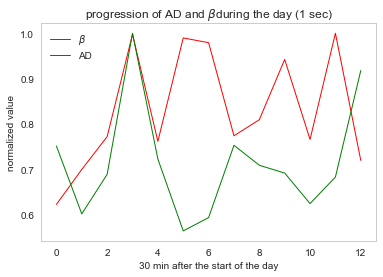

In [43]:
# progression of AVD_i and Beta_i, D = 1 sec
title = 'progression of AD and ' + r'$\beta$' + 'during the day (' + str(1) + ' sec)'
plt.figure()
lines1 = plt.plot(betas / np.max(betas), label = r'$\beta$')
plt.setp(lines1, 'color', 'r', 'linewidth', 1.0)
lines2 = plt.plot(AVD / np.max(AVD), label = 'AD')
plt.setp(lines2, 'color', 'g', 'linewidth', 1.0)
plt.xlabel('30 min after the start of the day', fontsize=10)
plt.ylabel('normalized value', fontsize=10)
plt.legend()
plt.title(title)
plt.show()

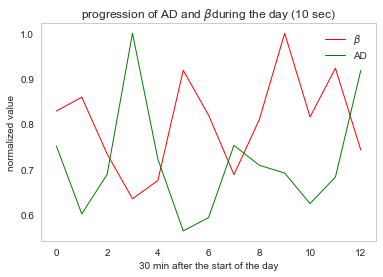

In [44]:
# progression of AVD_i and Beta_i, D = 10 sec
title = 'progression of AD and ' + r'$\beta$' + 'during the day (' + str(10) + ' sec)'
plt.figure()
lines1 = plt.plot(betas_10 / np.max(betas_10), label = r'$\beta$')
plt.setp(lines1, 'color', 'r', 'linewidth', 1.0)
lines2 = plt.plot(AVD_10 / np.max(AVD_10), label = 'AD')
plt.setp(lines2, 'color', 'g', 'linewidth', 1.0)
plt.xlabel('30 min after the start of the day', fontsize=10)
plt.ylabel('normalized value', fontsize=10)
plt.legend()
plt.title(title)
plt.show()

<b> PART 5 - log OLS on beta vs AD

In [45]:
# this function performs OLS on log AVD and log beta (to estimate lambda)
# takes also as a parameter D (time diff)
def OLS_beta(log_AVD,log_beta,D):
    
    # 1- OLS
    from sklearn import datasets, linear_model
    from sklearn.metrics import mean_squared_error, r2_score
    X_train = log_AVD[0:10]
    X_test = log_AVD[2:12]
    y_train = log_beta[0:10]
    y_test = log_beta[2:12]
    regr = linear_model.LinearRegression()
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)
    print('Coefficients: \n', regr.coef_)
    print("Mean squared error: %.2f"
              % mean_squared_error(y_test, y_pred))
    print('Variance score: %.2f' % r2_score(y_test, y_pred))
    
    # 2- qq-plot of y_test - y_pred against normal distribution
    import pylab 
    import scipy.stats as stats
    measurements = y_test[:,0] - y_pred[:,0]
    stats.probplot(measurements, dist="norm", plot=pylab)
    pylab.title('qq-plot against normal')
    pylab.show()

    # 3- qq-plot of y_test - y_pred against uniform distribution
    measurements = y_test[:,0] - y_pred[:,0]
    stats.probplot(measurements, dist="uniform", plot=pylab)
    pylab.title('qq-plot against uniform')
    pylab.show()

    # 4- post-OLS plot
    s = [5 for n in range(len(log_AVD))]
    title = 'OLS - average depth VS predicted coefficient (' + str(D) + ' sec)'
    plt.figure()
    plt.scatter(log_AVD,log_beta,s=s)
    lines = plt.plot(X_test, y_pred)
    plt.setp(lines, 'color', 'b', 'linewidth', 1.0)
    plt.xlabel(r'$\log AD_i$', fontsize=10)
    plt.ylabel(r'$\log \beta_i$', fontsize=10)
    plt.title(title)
    plt.show()

Coefficients: 
 [[-0.62316976]]
Mean squared error: 0.01
Variance score: 0.37


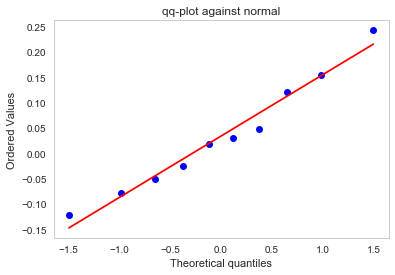

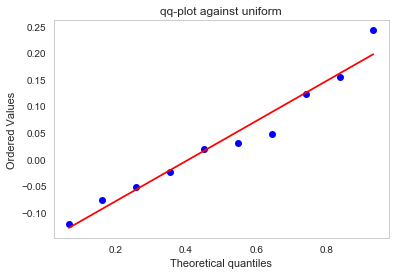

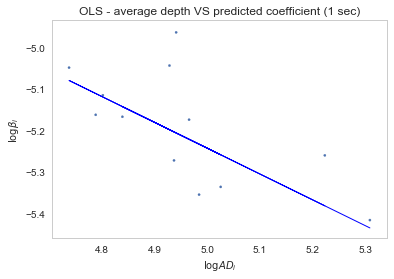

In [46]:
# on 1 sec
log_AVD = np.log(np.array(AVD_10)[1:])
log_AVD = log_AVD.reshape((log_AVD.shape[0],1))
log_beta = np.log(np.array(betas_10)[1:])
log_beta = log_beta.reshape((log_beta.shape[0],1))
OLS_beta(log_AVD,log_beta,1)